In [3]:
import pandas as pd

# 读取数据
file_path = 'data/carbonmonitor-cities_datas_2024-09-01.csv'
data = pd.read_csv(file_path)

C:\Users\MECHREV\AppData\Local\Temp\ipykernel_86272\2781553940.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')


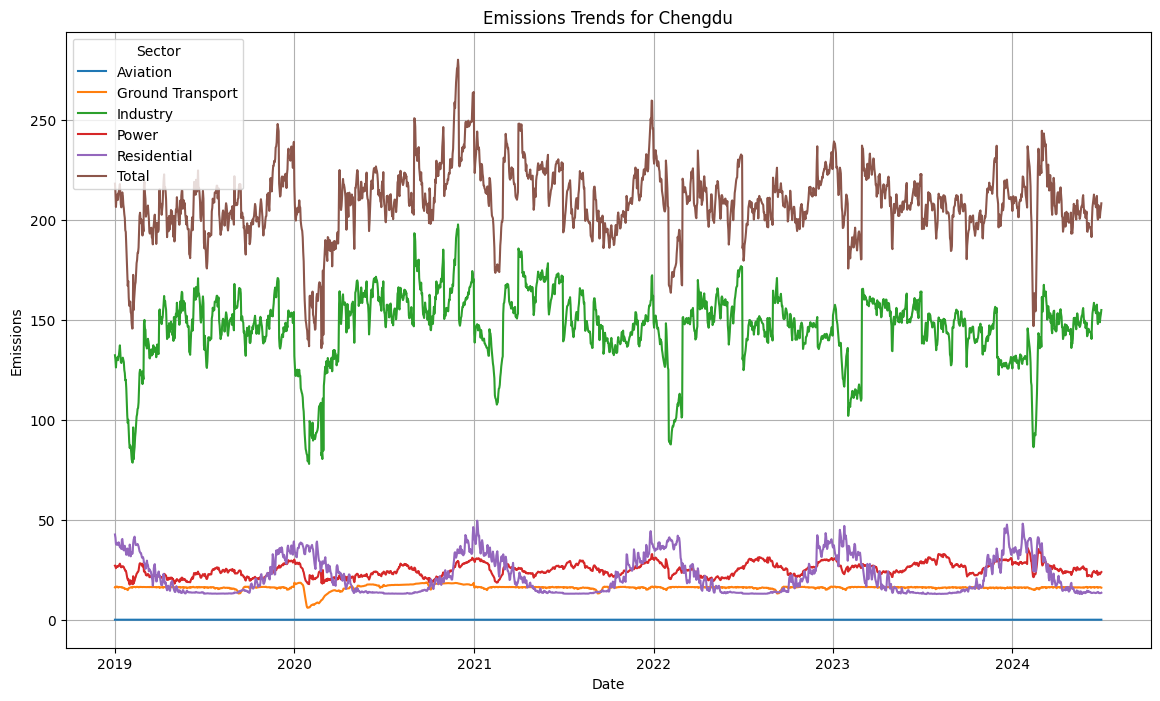

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter data for Melbourne
city_name = "Chengdu"
city_data = data[data['city'] == city_name]

# Convert date to datetime format for better plotting
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')

# Calculate the total emissions for all sectors
total_data = city_data.groupby('date')['value'].sum().reset_index()
total_data['sector'] = 'Total'

# Append the total data to the city data
city_data = pd.concat([city_data, total_data])

# Plotting the trends for each sector
plt.figure(figsize=(14, 8))

for sector in city_data['sector'].unique():
    sector_data = city_data[city_data['sector'] == sector]
    plt.plot(sector_data['date'], sector_data['value'], label=sector)

plt.title(f'Emissions Trends for {city_name}')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend(title='Sector')
plt.grid(True)
plt.show()

In [5]:
total_data

,date,value,sector
0,2019-01-01,217.972620,Total
1,2019-01-02,213.598146,Total
2,2019-01-03,206.311923,Total
3,2019-01-04,210.914219,Total
4,2019-01-05,211.633030,Total
...,...,...,...
2003,2024-06-26,204.139112,Total
2004,2024-06-27,200.961029,Total
2005,2024-06-28,203.895809,Total
2006,2024-06-29,205.631169,Total


In [6]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import ExpSineSquared

X = np.array(total_data['date'].index).reshape(-1, 1)
y = total_data['value']

In [7]:
X

array([[   0],
       [   1],
       [   2],
       ...,
       [2005],
       [2006],
       [2007]])

In [8]:
y

0       217.972620
1       213.598146
2       206.311923
3       210.914219
4       211.633030
           ...    
2003    204.139112
2004    200.961029
2005    203.895809
2006    205.631169
2007    208.141904
Name: value, Length: 2008, dtype: float64

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared

# 增加周期性参数的上限
kernel = ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds=(1e-2, 1e6))

# 初始化GPR模型
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

# 拟合模型
gp.fit(X, y)


AttributeError: 'GaussianProcessRegressor' object has no attribute 'kernel_'

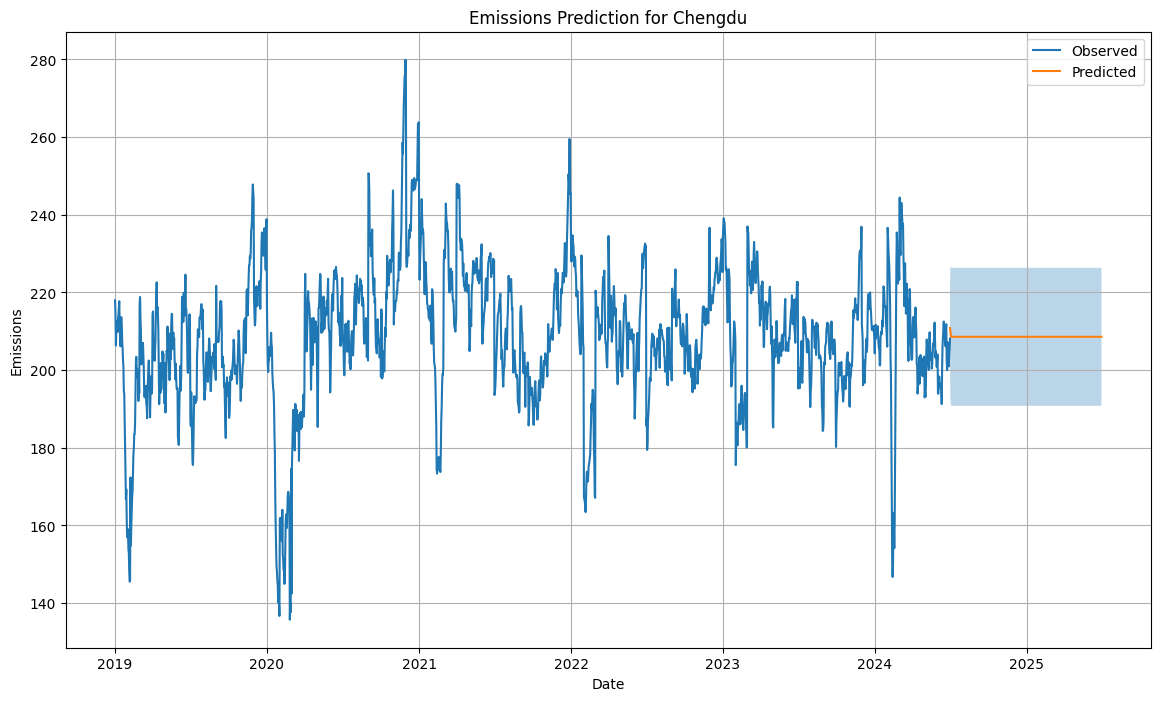

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假设 gp 是已经训练好的高斯过程模型，total_data 包含历史数据

# 生成未来365天的日期
X_future = np.arange(X.max() + 1, X.max() + 366).reshape(-1, 1)

# 预测未来365天的数据
y_pred, sigma = gp.predict(X_future, return_std=True)

# 生成未来365天的日期范围
future_dates = pd.date_range(start=total_data['date'].max(), periods=365, freq='D')

# 绘制预测结果
plt.figure(figsize=(14, 8))
plt.plot(total_data['date'], total_data['value'], label='Observed')
plt.plot(future_dates, y_pred, label='Predicted')
plt.fill_between(future_dates, y_pred - sigma, y_pred + sigma, alpha=0.3)
plt.title(f'Emissions Prediction for {city_name}')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()

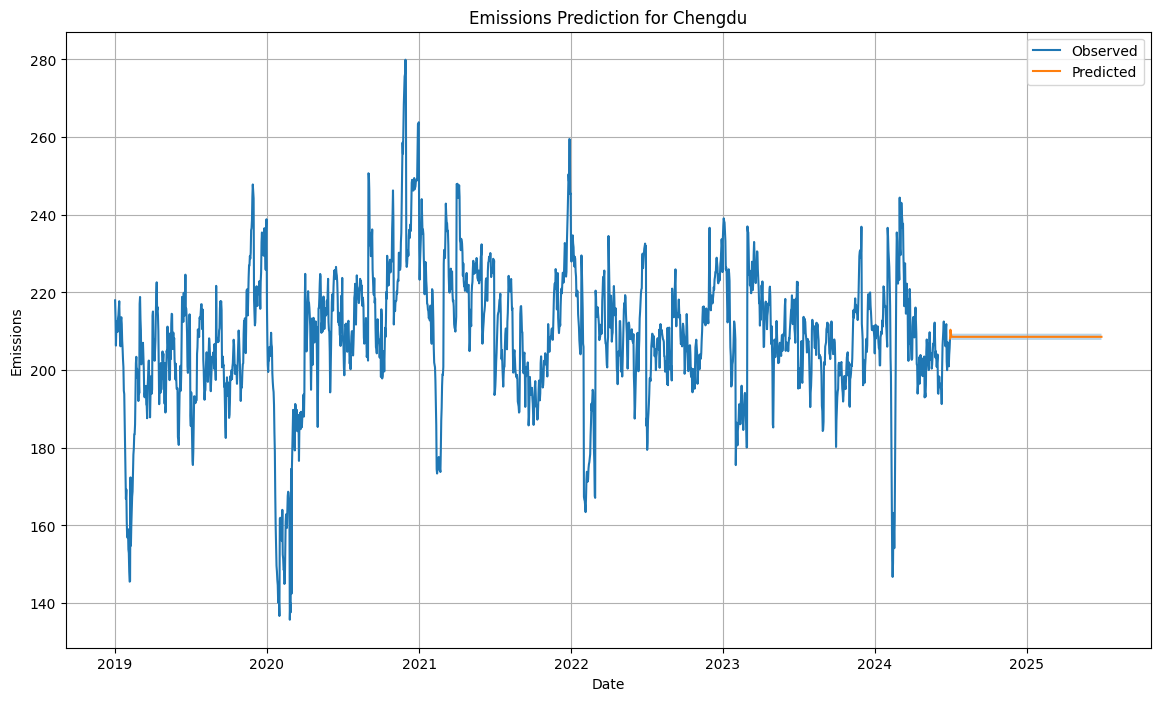

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# 假设 total_data 包含历史数据
# total_data = pd.read_csv('your_data.csv')  # 示例数据加载

# 提取日期特征
total_data['dayofyear'] = total_data['date'].dt.dayofyear
total_data['year'] = total_data['date'].dt.year

# 准备训练数据，确保 X 是 2D 数组
X = total_data[['dayofyear', 'year']].values
y = total_data['value'].values.reshape(-1, 1)

# 标准化数据
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y).ravel()

# 定义高斯过程模型
kernel = C(1.0, (1e-4, 1e1)) * RBF(10, (1e-4, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 训练模型
gp.fit(X_scaled, y_scaled)

# 生成未来365天的日期
future_dates = pd.date_range(start=total_data['date'].max(), periods=365, freq='D')
future_dayofyear = future_dates.dayofyear
future_year = future_dates.year
X_future = np.column_stack([future_dayofyear, future_year])

# 标准化未来数据
X_future_scaled = scaler_X.transform(X_future)

# 预测未来365天的数据
y_pred_scaled, sigma = gp.predict(X_future_scaled, return_std=True)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# 绘制预测结果
plt.figure(figsize=(14, 8))
plt.plot(total_data['date'], total_data['value'], label='Observed')
plt.plot(future_dates, y_pred, label='Predicted')
plt.fill_between(future_dates, y_pred.ravel() - sigma, y_pred.ravel() + sigma, alpha=0.3)
plt.title(f'Emissions Prediction for {city_name}')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()


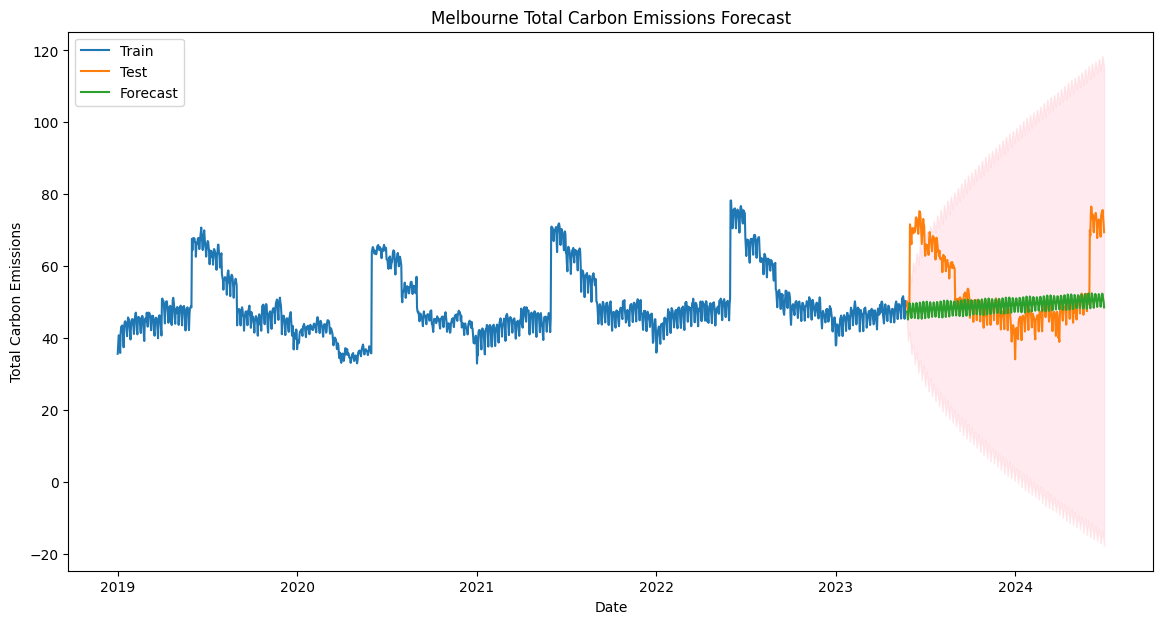

In [19]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = 'data/carbonmonitor-cities_datas_2024-09-01.csv'  # 请替换为你的文件路径
df = pd.read_csv(file_path)

# 将'date'列转换为datetime格式
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# 过滤墨尔本的数据
melbourne_total = df[df['city'] == 'Melbourne'].groupby(['city', 'date']).sum().reset_index()

# 确保'value'列为数值类型，并移除可能的NaN值
melbourne_total['value'] = pd.to_numeric(melbourne_total['value'], errors='coerce')
melbourne_total = melbourne_total.dropna(subset=['value'])

# 按日期排序
melbourne_total = melbourne_total.sort_values('date')

# 将数据集分为训练集（80%）和测试集（20%）
train_size = int(len(melbourne_total) * 0.8)
train_total = melbourne_total.iloc[:train_size]
test_total = melbourne_total.iloc[train_size:]

# 使用SARIMAX模型进行训练，不在这里传递maxiter
model_total = SARIMAX(train_total['value'], order=(4, 1, 5), seasonal_order=(1, 1, 1, 6))
result_total = model_total.fit(maxiter=500)  # 这里传递maxiter

# 进行预测
forecast_total = result_total.get_forecast(steps=len(test_total))
forecast_total_values = forecast_total.predicted_mean
forecast_total_ci = forecast_total.conf_int()

# 绘制预测结果
plt.figure(figsize=(14, 7))
plt.plot(train_total['date'], train_total['value'], label='Train')
plt.plot(test_total['date'], test_total['value'], label='Test')
plt.plot(test_total['date'], forecast_total_values, label='Forecast')
plt.fill_between(test_total['date'], forecast_total_ci.iloc[:, 0], forecast_total_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Total Carbon Emissions')
plt.title('Melbourne Total Carbon Emissions Forecast')
plt.legend()
plt.show()


In [20]:
import pandas as pd

# 读取用户上传的数据文件
file_path = 'data/carbonmonitor-cities_datas_2024-09-01.csv'
data = pd.read_csv(file_path)

# 查看数据的前几行
data.head()


,city,date,sector,value,timestamp
0,Melbourne,01/01/2019,Aviation,0.000817,1546300800
1,Melbourne,02/01/2019,Aviation,0.000935,1546387200
2,Melbourne,03/01/2019,Aviation,0.001007,1546473600
3,Melbourne,04/01/2019,Aviation,0.000954,1546560000
4,Melbourne,05/01/2019,Aviation,0.000958,1546646400


In [22]:
# 过滤出与墨尔本相关的数据，并选择日期和浓度值
melbourne_data = data[(data['city'] == 'Melbourne') & (data['sector'] == 'Aviation')].copy()

# 转换日期格式为 datetime 格式
melbourne_data.loc[:, 'date'] = pd.to_datetime(melbourne_data['date'], format='%d/%m/%Y')

# 按日期排序
melbourne_data = melbourne_data.sort_values(by='date')

# 查看处理后的数据
melbourne_data.head()


,city,date,sector,value,timestamp
0,Melbourne,2019-01-01 00:00:00,Aviation,0.000817,1546300800
1,Melbourne,2019-01-02 00:00:00,Aviation,0.000935,1546387200
2,Melbourne,2019-01-03 00:00:00,Aviation,0.001007,1546473600
3,Melbourne,2019-01-04 00:00:00,Aviation,0.000954,1546560000
4,Melbourne,2019-01-05 00:00:00,Aviation,0.000958,1546646400


In [8]:
import pandas as pd
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel
from sklearn.model_selection import train_test_split

# 读取CSV文件
file_path = 'data/carbonmonitor-cities_datas_2024-09-01.csv'
melbourne_data = pd.read_csv(file_path)

# 仅使用数据集的10%
melbourne_data = melbourne_data.sample(frac=0.1, random_state=42)

# 确保 'date' 列为 datetime 格式，并使用 dayfirst=True 参数
melbourne_data['date'] = pd.to_datetime(melbourne_data['date'], dayfirst=True)

# 将日期转换为时间戳
melbourne_data['timestamp'] = melbourne_data['date'].apply(lambda x: x.timestamp()).astype(float)
timestamps = melbourne_data['timestamp'].values
values = melbourne_data['value'].values

# 将数据拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(timestamps, values, test_size=0.2, random_state=42)

# 将数据转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 定义高斯过程模型
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 使用高斯似然性
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(X_train, y_train, likelihood)

# 训练模型
model.train()
likelihood.train()

optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

# 设置为评估模式
model.eval()
likelihood.eval()

# 进行预测
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(X_test))

# 打印预测结果
print(preds.mean[:5], y_test[:5])


tensor([20.3544, 23.3676, 47.4486, 39.7172, 38.6957]) tensor([1.4822e+01, 1.6297e+01, 2.4048e+01, 1.7202e-04, 2.3930e-05])


Total samples before sampling: 451800
Total samples after sampling: 22590


D:\CODE\short_term\short_term_proj\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


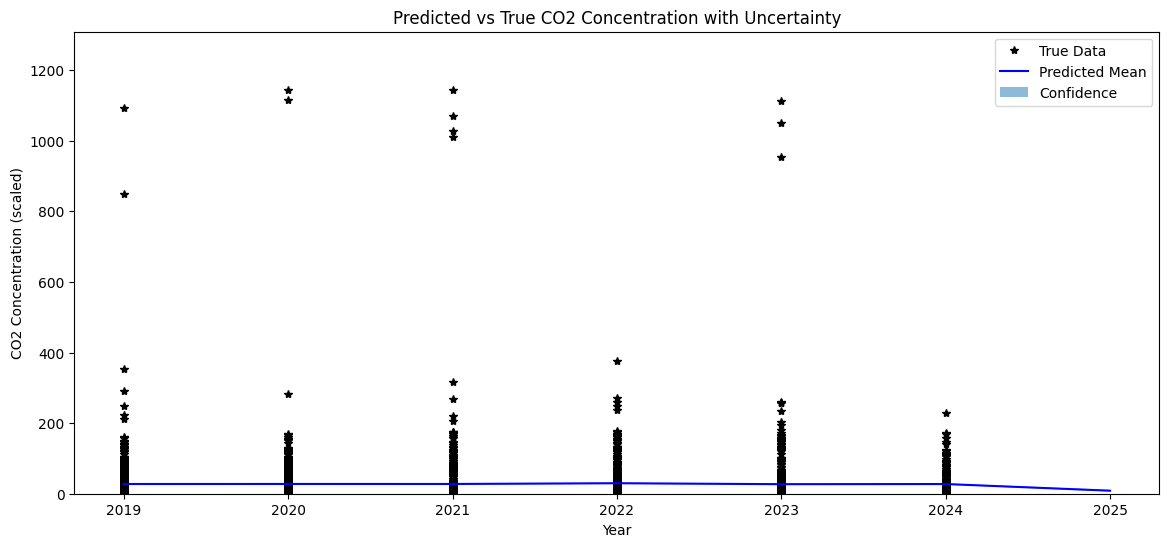

In [33]:
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt
from gpytorch.kernels import RBFKernel, ScaleKernel
from sklearn.model_selection import train_test_split

file_path = 'data/carbonmonitor-cities_datas_2024-09-01.csv'
melbourne_data = pd.read_csv(file_path)

# 确保 'date' 列为 datetime 格式，设置 dayfirst=True
melbourne_data['date'] = pd.to_datetime(melbourne_data['date'], dayfirst=True)

# 检查原始数据集的大小
print("Total samples before sampling:", len(melbourne_data))

# 进一步减少样本数量，比如减少到5%的数据
if len(melbourne_data) > 1000:  
    melbourne_data = melbourne_data.sample(frac=0.05, random_state=42)

# 检查采样后的数据量
print("Total samples after sampling:", len(melbourne_data))

# 转换时间戳为年份并标准化
melbourne_data['year'] = melbourne_data['date'].dt.year
years = melbourne_data['year'].values.astype(float)
values = melbourne_data['value'].values

# 拆分数据集
if len(melbourne_data) > 0:
    X_train, X_test, y_train, y_test = train_test_split(years, values, test_size=0.1, random_state=42)
else:
    raise ValueError("No data available after sampling")

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 定义简化的高斯过程模型
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 使用高斯似然性
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(X_train, y_train, likelihood)

# 训练模型，减少迭代次数
model.train()
likelihood.train()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 2  # 迭代次数减少为 20
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

# 模型评估
model.eval()
likelihood.eval()

# 预测未来一年的数据
years_future = torch.arange(X_test.min(), X_test.max() + 2, 1)
X_future = years_future.unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(X_future))

# 可视化结果
fig, ax = plt.subplots(figsize=(14, 6))

# 真实数据
ax.plot(X_test.squeeze().tolist(), y_test.tolist(), 'k*', label='True Data')

# 预测均值
ax.plot(years_future.tolist(), preds.mean.tolist(), 'b', label='Predicted Mean')

# 置信区间
lower, upper = preds.confidence_region()
ax.fill_between(years_future.tolist(), lower.tolist(), upper.tolist(), alpha=0.5, label='Confidence')

# 设置坐标轴和标题
ax.set_xlabel('Year')
ax.set_ylabel('CO2 Concentration (scaled)')
ax.set_title('Predicted vs True CO2 Concentration with Uncertainty')
ax.set_ylim([values.min() * 0.9, values.max() * 1.1])  # 适当缩放y轴
ax.legend()

plt.show()


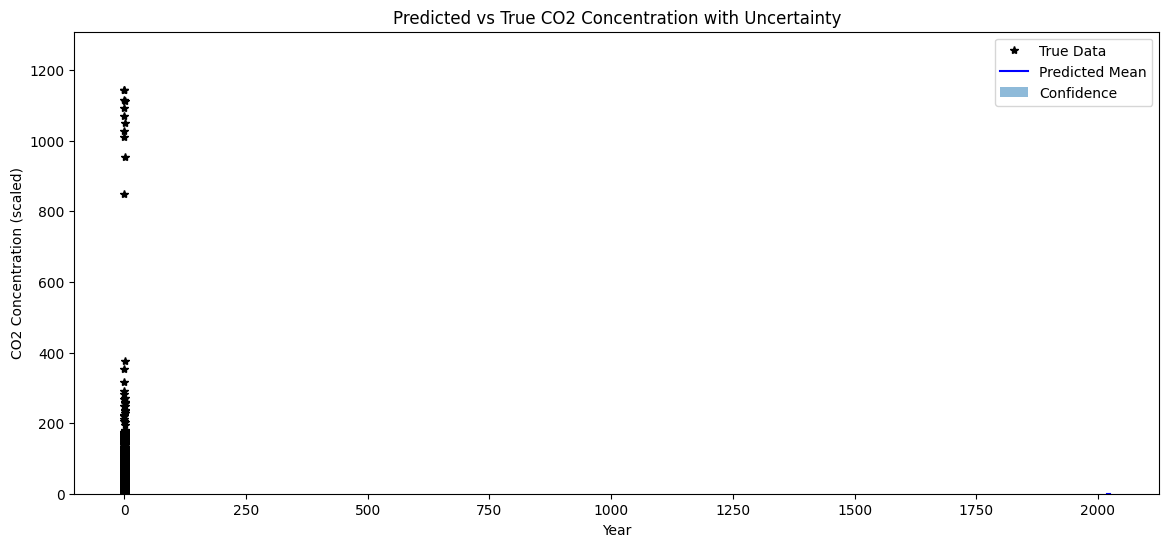

In [32]:
import torch
import matplotlib.pyplot as plt
import gpytorch

# 确保数据按年份排序
sorted_indices = X_test.squeeze().argsort()
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]

# 确保预测年份的顺序
years_future_sorted, _ = years_future.sort()

# 进行预测并可视化
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(years_future_sorted.unsqueeze(-1)))

# 绘制图表
fig, ax = plt.subplots(figsize=(14, 6))

# 绘制真实数据
ax.plot(X_test_sorted.squeeze().tolist(), y_test_sorted.tolist(), 'k*', label='True Data')

# 绘制预测均值
ax.plot(years_future_sorted.tolist(), preds.mean.tolist(), 'b', label='Predicted Mean')

# 绘制置信区间
lower, upper = preds.confidence_region()
ax.fill_between(years_future_sorted.tolist(), lower.tolist(), upper.tolist(), alpha=0.5, label='Confidence')

# 设置坐标轴和标题
ax.set_xlabel('Year')
ax.set_ylabel('CO2 Concentration (scaled)')
ax.set_title('Predicted vs True CO2 Concentration with Uncertainty')
ax.set_ylim([values.min() * 0.9, values.max() * 1.1])  # 适当缩放y轴
ax.legend()

plt.show()
